## **Step 1: Load the UCI Online Retail Dataset**

In [1]:
pip install ucimlrepo

In [2]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
online_retail = fetch_ucirepo(id=352)

# data (as pandas dataframes)
X = online_retail.data.features
y = online_retail.data.targets

# metadata
print(online_retail.metadata)

# variable information
print(online_retail.variables)


{'uci_id': 352, 'name': 'Online Retail', 'repository_url': 'https://archive.ics.uci.edu/dataset/352/online+retail', 'data_url': 'https://archive.ics.uci.edu/static/public/352/data.csv', 'abstract': 'This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.', 'area': 'Business', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate', 'Sequential', 'Time-Series'], 'num_instances': 541909, 'num_features': 6, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': None, 'index_col': ['InvoiceNo', 'StockCode'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2015, 'last_updated': 'Fri Jan 05 2024', 'dataset_doi': '10.24432/C5BW33', 'creators': ['Daqing Chen'], 'intro_paper': {'ID': 361, 'type': 'NATIVE', 'title': 'Data mining for the online retail industry: A case study of RFM model-based customer segmenta

In [3]:
X.head()

,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [9]:
data = X.copy()

## **Step 2: Import Libraries**


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


## **Step 3: Data Cleaning and Preprocessing**


In [10]:
data = data.dropna(subset=['CustomerID'])

data = data[(data['Quantity'] > 0) & (data['UnitPrice'] > 0)]

data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

data['TotalPrice'] = data['Quantity'] * data['UnitPrice']


In [12]:
data.columns

Index(['Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID',
       'Country', 'TotalPrice'],
      dtype='object')

## **Step 4: RFM Analysis for Segmentation**


In [16]:
## Recency = days since last purchase
## Frequency = count of unique purchase dates as a proxy for purchase frequency
## Monetary = total spending
reference_date = data['InvoiceDate'].max()
rfm = data.groupby('CustomerID').agg(
    Recency=('InvoiceDate', lambda x: (reference_date - x.max()).days),
    Frequency=('InvoiceDate', 'nunique'),
    Monetary=('TotalPrice', 'sum')
)
print(rfm.head())


            Recency  Frequency  Monetary
CustomerID                              
12346.0         325          1  77183.60
12347.0           1          7   4310.00
12348.0          74          4   1797.24
12349.0          18          1   1757.55
12350.0         309          1    334.40


In [19]:
rfm

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,1,7,4310.00
12348.0,74,4,1797.24
12349.0,18,1,1757.55
12350.0,309,1,334.40
...,...,...,...
18280.0,277,1,180.60
18281.0,180,1,80.82
18282.0,7,2,178.05


## **Step 5: Standardizing the Data**


In [17]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

rfm_scaled = pd.DataFrame(rfm_scaled, index=rfm.index, columns=rfm.columns)

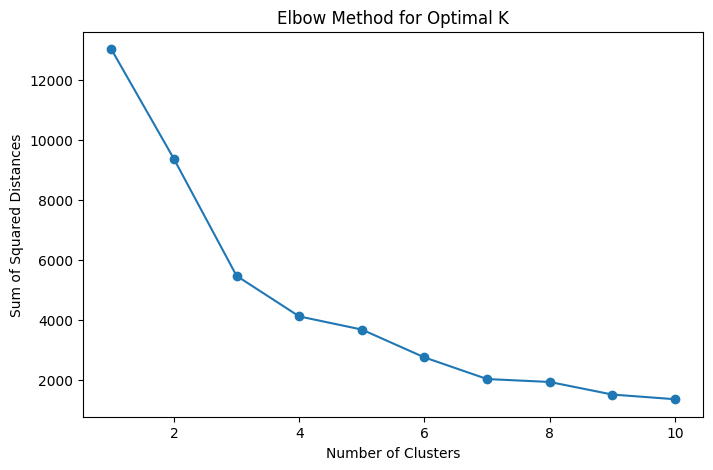

In [18]:
# Determine the optimal number of clusters using the Elbow Method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.show()


## **Step 6: Apply K-Means Clustering**


In [20]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

rfm.head()


,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,325,1,77183.60,0
12347.0,1,7,4310.00,1
12348.0,74,4,1797.24,1
12349.0,18,1,1757.55,1
12350.0,309,1,334.40,3



##Step 7: **Visualizing the Clusters**


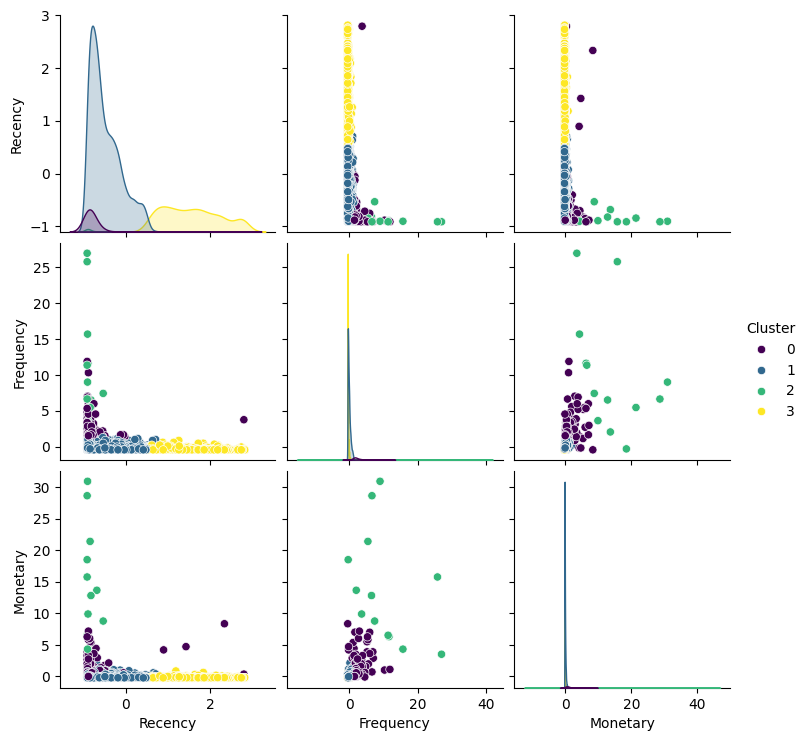

In [21]:
# Add cluster labels to the standardized RFM values
rfm_scaled['Cluster'] = rfm['Cluster']

# Plot the clusters
sns.pairplot(rfm_scaled, hue='Cluster', palette='viridis')
plt.show()


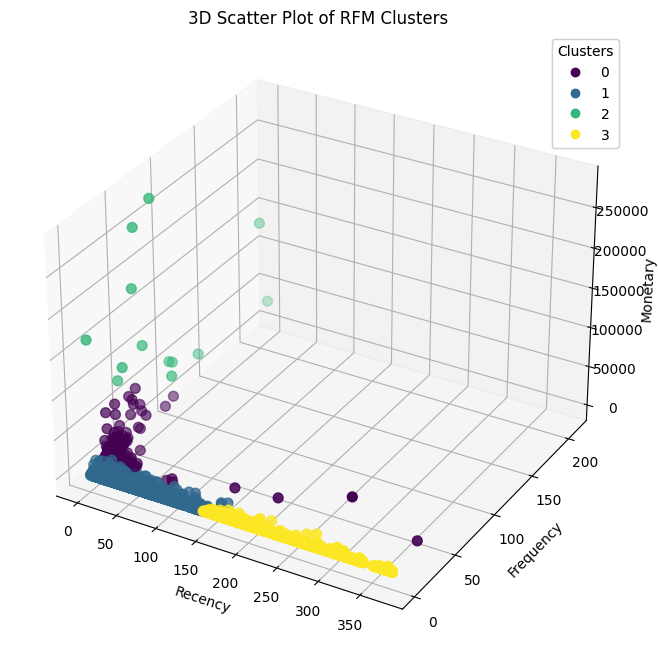

In [23]:
from mpl_toolkits.mplot3d import Axes3D

# 3D scatter plot for RFM clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot based on RFM values
scatter = ax.scatter(rfm['Recency'], rfm['Frequency'], rfm['Monetary'], c=rfm['Cluster'], cmap='viridis', s=50)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('3D Scatter Plot of RFM Clusters')

# Adding legend
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)
plt.show()


In [22]:
# Calculate average RFM values for each segment
segment_analysis = rfm.groupby('Cluster').mean()

# Display the segment analysis
print(segment_analysis)


            Recency  Frequency       Monetary
Cluster                                      
0         14.371429  21.861905   12444.119905
1         42.931870   3.648542    1354.403666
2          6.384615  81.692308  127338.313846
3        247.564030   1.551789     478.107581


## Using the Segments for Targeted Marketing

**Cluster 0:** Low recency, Moderate frequency, High Monrtary – Potential customers who recently purchased but have Moderate frequency. A good segment for loyalty programs.

**Cluster 1:** Moderate Recency, Low Frequency, Moderate Monetary – Loyal customers with frequent purchases and Moderate spending. .

**Cluster 2:** low Recency, Moderate Frequency, High Monetary – Occasional buyers who can be encouraged for more frequent purchases.Should be prioritized for special offers

**Cluster 3:** High Recency, Low Frequency, Low Monetary – Customers who haven’t engaged recently.Can be re-targeted with discounts.

## **Personalized MealPlans**

In [ ]:
## NLP
## Tokenize

from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import wordpunct_tokenize
from nltk.tokenize import TreebankWordTokenizer


## Stemming

from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem import RegexpStemmer
from nltk.stem import LancasterStemmer

## Lemmantatization
from nltk.stem import WordNetlemmatizer

## Stopwords
from nltk.corpus import stopwords
## WordCloud
from wordcloud import WordCloud


## Data preprocessing

## Lowercase
## Remove special Character
## Tokenize
## Stopwords and Punctuation
## Stemming and Lemmantizer
import
def transform_data(text):






